In [1]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

**Example of dog sound**

In [2]:
metadata = pd.read_csv("/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
# checking balanced or imbalanced
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

**Extract features**

**Extracting mfcc for every file**



In [4]:
!pip install resampy

In [5]:
audio_dataset_path = "/content/drive/MyDrive/UrbanSound8K/audio"

In [6]:
def feature_extractor(file):
  audio,sample_rate = librosa.load(file_name)
  mfccs_features = librosa.feature.mfcc(y=audio,sr = sample_rate,n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

  return mfccs_scaled_features

extracted_features = []
for index_num,row in tqdm(metadata.iterrows()):
  file_name= os.path.join(os.path.abspath(audio_dataset_path),'fold'+ str(row["fold"])+ "/",str(row["slice_file_name"]))
  final_class_labels = row['class']
  data = feature_extractor(file_name)
  extracted_features.append([data,final_class_labels])


3555it [01:37, 41.63it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8324it [03:34, 66.59it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [03:44, 38.98it/s]


In [7]:
extracted_features_df = pd.DataFrame(extracted_features, columns= ['feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing


In [8]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [9]:
X.shape

(8732, 40)

In [10]:
y.shape

(8732,)

In [13]:
#y= np.array(pd.get_dummies(y))
import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state= 0)

In [15]:
X_train.shape

(6985, 40)

In [16]:
X_test.shape

(1747, 40)

In [17]:
y_train.shape

(6985, 10)

In [18]:
y_test.shape

(1747, 10)

In [19]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [20]:
!sudo pip3 install keras

In [21]:
import keras
from tensorflow.python.keras.engine.sequential import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,Activation
#from tensorflow.python.keras.optimizers import Adam
from keras.optimizers import Adam
from sklearn import metrics

In [22]:
num_labels = y.shape[1]


In [23]:
model = Sequential()

model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [25]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='Adam')

In [27]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='audio_classification.hdf5',verbose=1,save_best_only=True)

start = datetime.now()

model.fit(X_train,y_train,batch_size=num_batch_size,epochs = num_epochs,validation_data = (X_test,y_test),callbacks=[checkpointer])

duration = datetime.now() - start

print("Training completed in time: ",duration)

Epoch 1/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9365 - accuracy: 0.6848 - val_loss: 0.7575 - val_accuracy: 0.7779

Epoch 00001: val_loss improved from inf to 0.75746, saving model to audio_classification.hdf5
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9565 - accuracy: 0.6780 - val_loss: 0.7800 - val_accuracy: 0.7750

Epoch 00002: val_loss did not improve from 0.75746
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9626 - accuracy: 0.6817 - val_loss: 0.7861 - val_accuracy: 0.7682

Epoch 00003: val_loss did not improve from 0.75746
Epoch 4/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9581 - accuracy: 0.6800 - val_loss: 0.7673 - val_accuracy: 0.7750

Epoch 00004: val_loss did not improve from 0.75746
Epoch 5/100
219/219 [==============================] - 0s 2ms/step - loss: 0.9559 - accuracy: 0.6809 - val_loss: 0.7613 - val_accuracy: 0.7722

Epoch 00005: val_loss did not imp

In [28]:
test_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7962220907211304


# **Testing**

In [33]:
filename = "/content/14113-4-0-0.wav"

In [34]:
import IPython.display as ipd

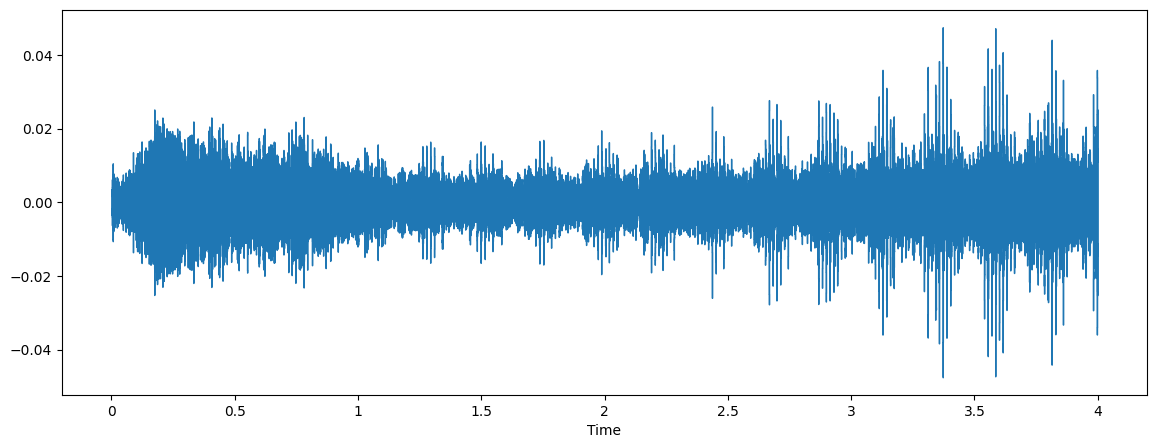

In [35]:
plt.figure(figsize=(14,5))
data,sample_rate = librosa.load(filename)
librosa.display.waveshow(data,sr= sample_rate)
ipd.Audio(filename)

In [38]:
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

#print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
print(prediction_class)

(1, 40)
[7]
['jackhammer']


/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
